In [93]:
#load necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.signal import find_peaks

In [94]:
#load data
data = np.loadtxt('chirp_test2.txt')*1000 #convert to mV

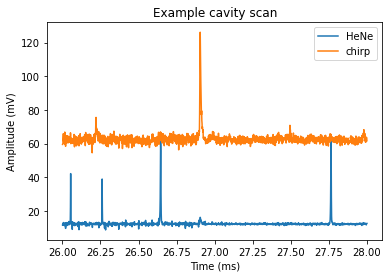

In [95]:
#make example plot of cavity scan data for one scan

#manually set parameters
#--------------------------------
sample_rate = 750e3 #750k samples/second
cav_scan_freq = 500 #frequency of cavity scan in Hz
#--------------------------------

#other dependent parameters
num_samples = len(data[0]) #number of samples in the data
duration = num_samples/sample_rate*1000 #duration of entire chirp scan in ms
dt = 1/sample_rate*1000 #time between samples in ms

cav_scan_duration = 1/cav_scan_freq*1000 #duration of one cavity scan in ms
cav_scan_num_samples = int(round(cav_scan_duration/dt)) #number of samples in one cavity scan

#plot the data
t = np.linspace(0, duration, num_samples) #time axis in ms
mask = (t>26) & (t<28) #mask to only plot a small section of the data (here, between 26 ms and 28 ms)
plt.plot(t[mask], data[0][mask], label='HeNe')
plt.plot(t[mask], data[1][mask], label='chirp')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (mV)')
plt.title('Example cavity scan')
plt.legend()
plt.show()

"\n#each index is 2 ms/1500 samples = 1.33 us/sample\ndt = 2/1500\nfor i, d in enumerate(chopped_data):\n    HeNe_peaks, _ = find_peaks(d[0], height=50)\n    chirp_peaks, _ = find_peaks(d[1], height=30+60)\n    print((chirp_peaks[0]-HeNe_peaks[0])/(HeNe_peaks[1]-HeNe_peaks[0])*500)\n\n\n    # plt.plot(d[0], label='HeNe')\n    # plt.plot(d[1], label='chirp')\n    # plt.xlabel('Time (ms)')\n    # plt.legend()\n    # plt.show()\n\n"

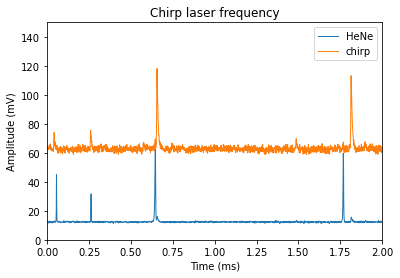

In [99]:
#make animation of chirp

chopped_data = np.array_split(data, num_samples//cav_scan_num_samples, axis=1)
t_chopped = np.linspace(0, cav_scan_duration, cav_scan_num_samples)

# Create a figure and axes
fig, ax = plt.subplots()

# Set up limits of the plot and labels
ax.set_xlim(0, 2)
ax.set_ylim(0, 150)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (mV)')
ax.set_title('Chirp laser frequency')

# Initialize a line object (this will be updated in each frame)
line, = ax.plot([], [], lw=1, label='HeNe')
line2, = ax.plot([], [], lw=1, label='chirp')
ax.legend()

# Initialization function to set the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    return line, line2,

# Animation function which updates the plot in each frame
def animate(i):
    line.set_data(t_chopped, chopped_data[i][0])
    line2.set_data(t_chopped, chopped_data[i][1])
    return line, line2,

# Call the animator, blit=True means only re-draw the parts that have changed
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=num_samples//cav_scan_num_samples,interval=100, blit=False, repeat=False)

# Save the animation as an mp4 file
ani.save('chirp.mp4', writer='ffmpeg')

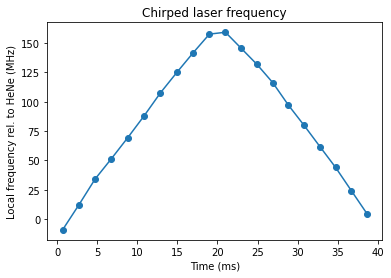

In [109]:
#analyze peaks and extract frequency chirp

#manually set parameters
#--------------------------------
HeNe_threshold = 50 # in mV
chirp_threshold = 30+60 # in mV, add 60 mV for baseline offset
cavity_fsr = 500 # cavity free spectral range in MHz
#--------------------------------

#initialize arrays for the peak detection times and local frequencies

chirped_laser_peak_times = np.empty(num_samples//cav_scan_num_samples)
chirped_laser_local_freqs = np.empty(num_samples//cav_scan_num_samples)

#find peaks and calculate local frequency
for i, d in enumerate(chopped_data):
    HeNe_peaks, _ = find_peaks(d[0], height=HeNe_threshold)
    chirp_peaks, _ = find_peaks(d[1], height=chirp_threshold)
    HeNe_separation = HeNe_peaks[1]-HeNe_peaks[0]
    local_freq = (chirp_peaks[0]-HeNe_peaks[0])/HeNe_separation*cavity_fsr
    peak_time = (chirp_peaks[0]+cav_scan_num_samples*i)*duration/num_samples
    chirped_laser_peak_times[i] = peak_time
    chirped_laser_local_freqs[i] = local_freq

#plot the peak detection time versus chirped local frequency
plt.plot(chirped_laser_peak_times, chirped_laser_local_freqs, 'o-')
plt.xlabel('Time (ms)')
plt.ylabel('Local frequency rel. to HeNe (MHz)')
plt.title('Chirped laser frequency')
plt.show()